# Click dataset

In [1]:
from joblib import load, dump
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras import layers, regularizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

2024-03-01 22:26:23.110918: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 22:26:23.110963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 22:26:23.112009: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-01 22:26:23.118631: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-01 22:26:23.846737: W tensorflow/compiler/tf2

## Preparation


Convert whole keyboard to only click or not click.

In [2]:
# x_orig, y_orig = load("dataset-click/dataset.joblib")

# y = np.zeros(shape=(y_orig.shape[0],))
# y[:] = np.int8(np.any(y_orig == 1, axis=1))

# x = np.zeros(shape=(x_orig.shape[0], 163))
# x[:] = np.hstack((x_orig[:,:-17], np.any(x_orig[:, -17:] == 1, axis=1).reshape((x_orig.shape[0],1))))

x_train, y_train, x_dev, y_dev, x_test, y_test = load("dataset-jufo/dataset.joblib")

Train-test-split: (split was moved to data preparation)

In [3]:
# x_train, x_dev, y_train, y_dev = train_test_split(x, y, test_size=0.2, random_state=21)
# x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=100)

## Simple tensorflow model

A simple tf architecture with 3 layers and relu activation functions inbetween:
- Dense (5000 neurons)
- Dense (5000 neurons)
- Dense (5000 neurons)
- Dense (5000 neurons)

The last layer has a sigmoid activation function to make mapping to 0 and 1 easier.
Additionally, there is L2 regularization in place.

In [4]:
inputs = layers.Input(shape=(179,))
normalizer = layers.Normalization()
normalizer.adapt(x_train)
x = normalizer(inputs)
for _ in range(4):
    x = layers.Dense(5000, activation = "relu", kernel_regularizer=regularizers.l2(0.001))(x)
outputs = layers.Dense(17, activation = "sigmoid")(x)
model = keras.Model(inputs, outputs)

# model = keras.Sequential(
#     [
#         # add standardization!
#         layers.Input(shape=(179,)),
#         layers.Dense(5000, activation = "relu",
#                      kernel_regularizer=regularizers.l2(0.001)),
#         layers.Dense(5000, activation = "relu",
#                      kernel_regularizer=regularizers.l2(0.001)),
#         layers.Dense(5000, activation = "relu",
#                      kernel_regularizer=regularizers.l2(0.001)),
#         layers.Dense(5000, activation = "relu",
#                      kernel_regularizer=regularizers.l2(0.001)),
#         layers.Dense(17, activation = "sigmoid")
#     ]
# )

2024-03-01 22:26:24.885070: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 22:26:24.931887: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 22:26:24.932125: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Metric
_See https://github.com/xjjak/LapCal/issues/28_

Use a weighted combination of:
- accuracy
- precision
- recall
- auc

Try to incorporate how well state changes are handled (eg. maybe penalty or something similar).

_Possibly redefine positive negative predictions to state changes._

In [5]:
# import keras.backend as K
# import math

# def recall(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall_keras = true_positives / (possible_positives + K.epsilon())
#     return recall_keras


# def precision(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision_keras = true_positives / (predicted_positives + K.epsilon())
#     return precision_keras


# eps = 1e-10

# def fbeta(y_true, y_pred, beta=1):
#     r = K.clip(recall(y_true, y_pred), eps, 1)
#     p = K.clip(precision(y_true, y_pred), eps, 1)
#     return (1 + beta**2) * (p * r) / (beta**2 * p + r)

# # unused
# def prediction_boundary(y_true, y_pred):
#     tn = K.mean((1 - y_true) * y_pred)
#     tp = K.mean(y_true * y_pred)
#     return K.clip(tp - tn, 0, 1)


# def inv_distance(y_true, y_pred):
#     return K.clip(1 - 2*K.mean(K.abs(y_true - y_pred)), 0, 1)


# def custom_metric(y_true, y_pred):
#     metrics = [precision, lambda *x: fbeta(*x, beta=2), keras.metrics.binary_accuracy, inv_distance]
#     coeff   = [0.1      , 0.6                         , 0.2                          , 0.1         ]
#     return sum([c * metric(y_true, y_pred) for c, metric in zip(coeff, metrics)])

In [6]:
from metric import *

#### Tests

In [7]:
class CustomMetric(keras.metrics.Metric):
    def __init__(self, metrics = [], name='custom', **kwargs):
        super(CustomMetric, self).__init__(name=name, **kwargs)
        self._binacc    = keras.metrics.BinaryAccuracy()
        self._precision = keras.metrics.Precision()
        self._recall    = keras.metrics.Recall()
        self._auc       = keras.metrics.AUC()
        
        self._metrics = [self._binacc, self._precision, self._recall, self._auc]
        self._coeff   = [0.1        , 0.4           , 0.4        , 0.1     ]

        # self._result = tf.constant(0, shape = (), dtype = tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        for metric in self._metrics:
            metric.update_state(y_true, y_pred, sample_weight=sample_weight)

    def result(self):
        return sum([c * metric.result() for c, metric in zip(self._coeff, self._metrics)])

In [8]:
# import tensorflow_model_analysis as tfma

# metrics = [
#     keras.metrics.BinaryAccuracy(name = "binacc"),
#     keras.metrics.Precision(name = "precision"),
#     keras.metrics.Recall(name = "recall"),
#     keras.metrics.AUC(name = "auc")
# ]
# metrics_specs = tfma.metrics.specs_from_metrics(
#     metrics,
#     aggregate=tfma.AggregationOptions(
#         # macro_average=True, class_weights={i: 1.0 for i in range(10)}
#         micro_average=True
#     )
# )

Use `Callback` to insert the result of the custom metric instead of `Metric` class as it is more complicated and there is no need for the class per se.

In [30]:
# class MergeMetrics(keras.callbacks.Callback):
#     def __init__(self, **kwargs):
#         super(MergeMetrics, self).__init__(**kwargs)

#     def on_epoch_begin(self, epoch, logs={}):
#         return

#     def on_epoch_end(self, epoch, logs={}):
#         # logs['merge_metrics'] = 0.5*logs["y1_mse"]+0.5*logs["y2_mse"]
#         metrics = ["binacc", "precision", "recall", "auc"]
#         coeff   = [0.1     , 0.4        , 0.4     , 0.1  ]
#         logs['metric'] = sum([c * logs[metric] for c, metric in zip(coeff, metrics)])
#         logs['val_metric'] = sum([c * logs['val_'+metric] for c, metric in zip(coeff, metrics)])

### Hyperparameters

In [13]:
learning_rate = 1e-4
optimizer = keras.optimizers.RMSprop
# optimizer = keras.optimizers.Adam
# loss = keras.losses.BinaryFocalCrossentropy
loss = keras.losses.BinaryCrossentropy

# @keras.saving.register_keras_serializable(package="my_package", name="f2")
def f2(*x):
    fbeta(*x, beta=2)

metrics = [
    custom_metric,
    binary_accuracy,
    recall,
    # f2,
    inv_distance,
]

### Compilation

In [14]:
model.compile(
    optimizer = optimizer(learning_rate=learning_rate),
    loss = loss(),
    metrics = metrics
)

### Training

Prepare sample weights:

In [15]:
# https://github.com/xjjak/LapCal/issues/29#issuecomment-1930880677
standard_weight = 1
change_weight = 5

y_before = x_train[:,-17:]
changes = np.any(y_before != y_train, axis=1)
sample_weight = (changes*(change_weight - standard_weight) + standard_weight)

xf, yf = x_train[changes == False], y_train[changes == False]
xt, yt = x_train[changes == True ], y_train[changes == True ]

Prepare undersampling sets:new(LB, list_browser), right

In [16]:
# https://github.com/xjjak/LapCal/issues/29#issuecomment-1939578746
# https://github.com/xjjak/LapCal/issues/29#issuecomment-1969695787
indices = np.arange(xf.shape[0])
np.random.shuffle(indices)

# multiple of positive to sample from negative set
n = 10
x_ = xf[indices[:min(n*changes.sum(), len(indices))]]
y_ = yf[indices[:min(n*changes.sum(), len(indices))]]

x_us = np.vstack((x_, xt))
y_us = np.vstack((y_, yt))

from sklearn.utils import shuffle
x_us, y_us = shuffle(x_us, y_us, random_state=0)
(x_us.shape, y_us.shape)

((1410, 179), (1410, 17))

Prepare oversampling sets:

In [17]:
# how often to oversample the positive set
n = len(xf) // len(xt)
x_os = np.vstack((xf,)+(xt,)*n)
y_os = np.vstack((yf,)+(yt,)*n)

from sklearn.utils import shuffle
x_os, y_os = shuffle(x_os, y_os, random_state=0)
(x_os.shape, y_os.shape)

((2380, 179), (2380, 17))

Train the model:

In [18]:
n_epochs = 500
batch_size = 32
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(
    x_os, y_os,
    batch_size=batch_size,
    epochs=n_epochs,
    # sample_weight=sample_weight,
    validation_data=(x_dev, y_dev),
    callbacks=[early_stopping],
    # use_multiprocessing=True # not applicable?
)

Epoch 1/500


2024-03-01 22:26:54.611010: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f002c87b280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-01 22:26:54.611075: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-03-01 22:26:54.625331: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-01 22:26:54.646417: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1709328414.705027   63959 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 [==============================] - 5s 33ms/step - loss: 14.7539 - custom_metric: 0.6433 - binary_accuracy: 0.9788 - recall: 0.4687 - inv_distance: 0.8693 - val_loss: 14.0125 - val_custom_metric: 0.8454 - val_binary_accuracy: 0.9891 - val_recall: 0.9140 - val_inv_distance: 0.9529
Epoch 2/500
75/75 [==============================] - 2s 31ms/step - loss: 13.3753 - custom_metric: 0.8742 - binary_accuracy: 0.9939 - recall: 0.8002 - inv_distance: 0.9721 - val_loss: 12.7484 - val_custom_metric: 0.8384 - val_binary_accuracy: 0.9929 - val_recall: 0.7697 - val_inv_distance: 0.9717
Epoch 3/500
75/75 [==============================] - 2s 30ms/step - loss: 12.1722 - custom_metric: 0.9103 - binary_accuracy: 0.9953 - recall: 0.8605 - inv_distance: 0.9799 - val_loss: 11.6026 - val_custom_metric: 0.8743 - val_binary_accuracy: 0.9945 - val_recall: 0.8184 - val_inv_distance: 0.9768
Epoch 4/500
75/75 [==============================] - 2s 31ms/step - loss: 11.0775 - custom_metric: 0.9287 - binary_acc

### Plots and Stats

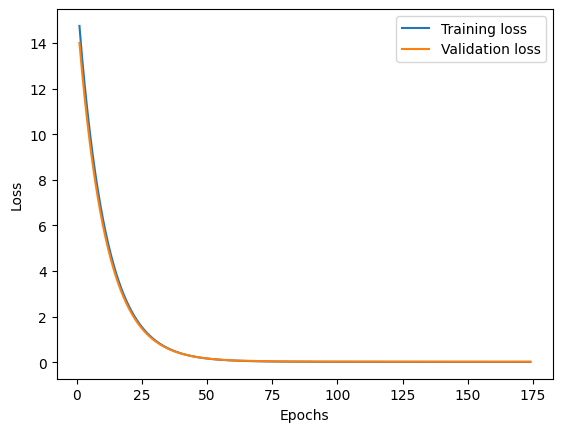

In [19]:
n = len(history.history['loss'])

offset = 0

plt.plot(range(1 + offset, n+1), history.history['loss'][offset:], label="Training loss")
plt.plot(range(1 + offset, n+1), history.history['val_loss'][offset:], label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

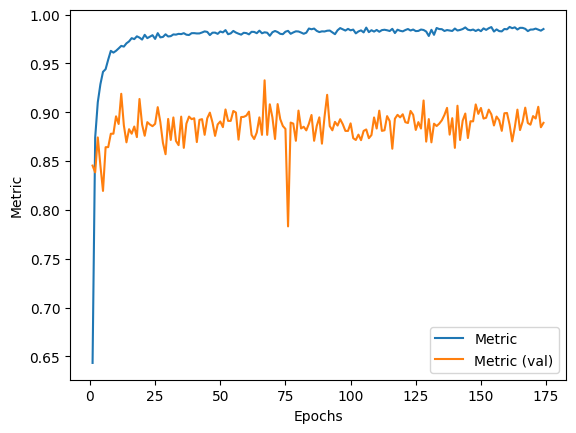

In [20]:
plt.plot(range(1 + offset, n+1), history.history['custom_metric'][offset:], label="Metric")
plt.plot(range(1 + offset, n+1), history.history['val_custom_metric'][offset:], label="Metric (val)")

plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.show()

In [21]:
plt.plot(range(1 + offset, n+1), history.history['<lambda>'][offset:], label="f_2")
plt.plot(range(1 + offset, n+1), history.history['val_<lambda>'][offset:], label="f_2 (val)")

plt.xlabel('Epochs')
plt.ylabel('$f_2$')
plt.legend()
plt.show()

KeyError: '<lambda>'

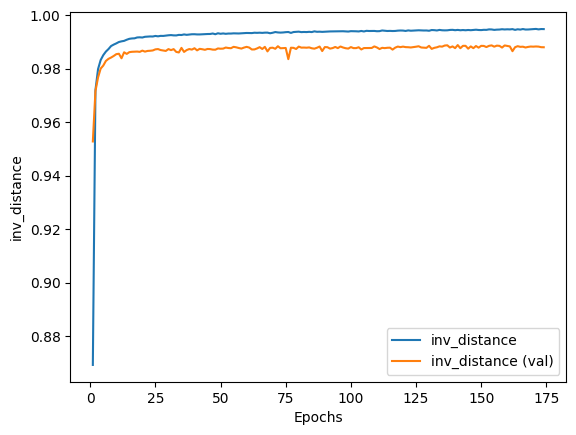

In [23]:
plt.plot(range(1 + offset, n+1), history.history['inv_distance'][offset:], label="inv_distance")
plt.plot(range(1 + offset, n+1), history.history['val_inv_distance'][offset:], label="inv_distance (val)")

plt.xlabel('Epochs')
plt.ylabel('inv_distance')
plt.legend()
plt.show()

In [27]:
y_pred = model.predict(x_dev)
print(
    (y_dev == 1).sum(),
    (y_pred > 1e-3).sum(),
    (y_pred > 1e-2).sum(),
    (y_pred > 1e-1).sum(),
    (y_pred > 5e-1).sum(),
)

(model.evaluate(x_train, y_train), model.evaluate(x_dev, y_dev))

12/12 [==============================] - 0s 3ms/step
101 223 168 130 98
12/12 [==============================] - 0s 7ms/step - loss: 0.0223 - custom_metric: 0.8892 - binary_accuracy: 0.9950 - recall: 0.8250 - inv_distance: 0.9881


([0.010979818180203438,
  0.9797349572181702,
  0.9989985823631287,
  0.9829012751579285,
  0.9952501654624939],
 [0.022304099053144455,
  0.8892107605934143,
  0.9949765205383301,
  0.8249579071998596,
  0.9880843162536621])

Save the model:

In [22]:
import os
name = "oversampling-5-click"
path = f'{name}.keras'
assert not os.path.exists(path), "Name is not unique"
model.save(path)
# TODO: add history

# UserWarning: The object being serialized includes a `lambda`. This is unsafe.
# In order to reload the object, you will have to pass `safe_mode=False` to the
# loading function. Please avoid using `lambda` in the future, and use named
# Python functions instead. This is the `lambda` being serialized:
#    lambda *x: fbeta(*x, beta=2),

AssertionError: Name is not unique

Load a model:

In [18]:
model_l = keras.models.load_model("oversampling-4.keras", safe_mode=False)

### Evaluation

Do not make changes to optimize this value, optimize dev set instead.

In [25]:
model.evaluate(x_test, y_test)

8/8 [==============================] - 0s 7ms/step - loss: 0.0215 - custom_metric: 0.9265 - binary_accuracy: 0.9966 - recall: 0.8891 - inv_distance: 0.9900


[0.0214606374502182,
 0.9264504313468933,
 0.9965970516204834,
 0.8891369104385376,
 0.9899890422821045]